In [1]:
import sys
print(sys.version)
print(sys.path)

3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 18:53:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
['/Users/tokudo/Develop/grips/unicorn/notebooks', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python36.zip', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6/lib-dynload', '', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6/site-packages', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6/site-packages/aeosa', '/Users/tokudo/Develop/grips/grina', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6/site-packages/locket-0.2.1-py3.6.egg', '/Users/tokudo/opt/anaconda3/envs/grips/lib/python3.6/site-packages/IPython/extensions', '/Users/tokudo/.ipython', '/Users/tokudo/.local/lib/python3.6/site-packages', '/Users/tokudo/.local/lib/python3.6/site-packages']


In [141]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import grina
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = ['Times New Roman']

In [3]:
out_dir = os.path.join("..", "out", "202202")
out_dir_names = ["edgelist", "features", "adjacency"]
for out_dir_name in out_dir_names:
    out_path = os.path.join(out_dir, out_dir_name)
    if not os.path.exists(out_path):
        os.makedirs(out_path)

In [4]:
def trans2float(x):
    y = x[1:]
    return float(y)

In [5]:
fpath = os.path.join("..", "data", "cb-insights_global-unicorn-club_2022.csv")
df = pd.read_csv(fpath, converters={"Select Investors": lambda x: x.split(",")})
df["Valuation($B) flaot"] = df['Valuation ($B) '].apply(trans2float)
df["DateTime Joined"] = df["Date Added"].apply(lambda x: datetime.datetime.strptime(x, "%Y/%m/%d"))
df.head()

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
0,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,"[Sequoia Capital China, SIG Asia Investments,...",140.0,2017-04-07
1,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.3,2012-12-01
2,Stripe,$95.00,2014/1/23,United States,Fintech,"[Khosla Ventures, LowercaseCapital, capitalG]",95.0,2014-01-23
3,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.6,2011-12-12
4,Epic Games,$42.00,2018/10/26,United States,Other,"[Tencent Holdings, KKR, Smash Ventures]",42.0,2018-10-26


In [6]:
df["Valuation($B) flaot"].describe()

count    1000.000000
mean        3.307270
std         7.405112
min         1.000000
25%         1.070000
50%         1.600000
75%         3.100000
max       140.000000
Name: Valuation($B) flaot, dtype: float64

In [7]:
# Unicornに重複がある場合に、suffixとして"_"を付与。
duplicated_company_idx = (df["Company"].duplicated(), "Company")
df.loc[duplicated_company_idx] = df.loc[duplicated_company_idx].apply(func=lambda x: str(x) + "+")
df[df["Company"].duplicated()]

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined


In [8]:
def clean(element):
    return element.strip()

In [9]:
# UnicornとInvestorのエッジリストの作成
r_comps, r_invests = [], []
for company, investors in df[["Company", "Select Investors"]].values.tolist():
    n_rows = len(investors)
    comps = np.full(n_rows, company)
    r_comps += comps.tolist()
    r_invests += investors
r_comps = list(map(clean, r_comps))
r_invests = list(map(clean, r_invests))

In [10]:
# Unicornで投資を行っている企業が存在するため、2部グラフにするためにInvester&Unicornの場合はInvester名に"_"を追加
for i, invest in enumerate(r_invests):
    if invest in r_comps:
        print(invest)
        r_invests[i] = invest + "_"

Stripe
Digital Currency Group
Stripe
Digital Currency Group
Movile
Bitmain Technologies


In [11]:
rdf = pd.DataFrame()
rdf["Company"] = np.array(r_comps)
rdf["Investors"] = np.array(r_invests)
rdf

,Company,Investors
0,Bytedance,Sequoia Capital China
1,Bytedance,SIG Asia Investments
2,Bytedance,Sina Weibo
3,Bytedance,Softbank Group
4,SpaceX,Founders Fund
...,...,...
2825,Betterfly,DST Global
2826,Betterfly,Endeavor
2827,Dune Analytics,Multicoin Capital
2828,Dune Analytics,Coatue Management


In [12]:
B = nx.Graph()

In [13]:
B.add_nodes_from(rdf["Company"].unique().tolist(), bipartite=0)
B.add_nodes_from(rdf["Investors"].unique().tolist(), bipartite=1)

In [14]:
edges = [(comp, inve) for comp, inve in zip(rdf["Company"], rdf["Investors"])]
B.add_edges_from(edges)

In [15]:
from networkx.algorithms import bipartite
company_graph = bipartite.projected_graph(B, set(rdf["Company"].tolist()))
investor_graph = bipartite.projected_graph(B, set(rdf["Investors"].tolist()))

In [16]:
company_graph_pd = nx.to_pandas_edgelist(company_graph)

In [17]:
investor_graph_pd = nx.to_pandas_edgelist(investor_graph)

In [18]:
bipartite_graph_pd = nx.to_pandas_edgelist(B)

In [19]:
print("ファイルを出力しますか？[y/n]")
b = input()
if b == "y":
    bipartite_graph_pd.to_csv(os.path.join(out_dir, "edgelist", "bipartite_graph.csv"))
    company_graph_pd.to_csv(os.path.join(out_dir, "edgelist", "company_graph.csv"))
    investor_graph_pd.to_csv(os.path.join(out_dir, "edgelist", "investor_graph.csv"))
    print("Done!!")

ファイルを出力しますか？[y/n]
Done!!


# 2部グラフ分析

In [20]:
vc_invest_df = pd.merge(bipartite_graph_pd, df, left_on="source", right_on="Company", how="left")
vc_invest_df.drop(["Select Investors", "source"], axis=1, inplace=True)
vc_invest_df.head()

,target,Company,Valuation ($B),Date Added,Country,Category,Valuation($B) flaot,DateTime Joined
0,Sequoia Capital China,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,140.0,2017-04-07
1,SIG Asia Investments,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,140.0,2017-04-07
2,Sina Weibo,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,140.0,2017-04-07
3,Softbank Group,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,140.0,2017-04-07
4,Founders Fund,SpaceX,$100.30,2012/12/1,United States,Other,100.3,2012-12-01


In [21]:
analysis_invest_df = vc_invest_df.groupby("target", as_index=False).agg(
    {
        "Valuation($B) flaot": ["sum", "count", "mean"],
        "Country": [lambda x: len(x.unique()), set],
        "Category": [lambda x: len(x.unique()), set],
        "Company": [lambda x: len(x.unique()), set],
        "DateTime Joined": "min",
    }
)
analysis_invest_df

target Valuation($B) flaot                     Country  \
                                       sum count       mean <lambda_0>   
0        .406 Ventures                1.70     1   1.700000          1   
1          01 Advisors                9.35     2   4.675000          1   
2             10T Fund                7.10     1   7.100000          1   
3                  14W                2.50     2   1.250000          1   
4      14W. ForgeLight                1.10     1   1.100000          1   
...                ...                 ...   ...        ...        ...   
1192     iTech Capital                1.00     1   1.000000          1   
1193  iVision Ventures                1.00     1   1.000000          1   
1194    index Ventures               33.00     1  33.000000          1   
1195            next47                4.60     3   1.533333          2   
1196       s28 Capital                1.40     1   1.400000          1   

                                Category  \
                          set <lambda_0>   
0             {United States}          1   
1             {United States}          2   
2             {United States}          1   
3             {United States}          2   
4            {United Kingdom}          1   
...                       ...        ...   
1192            {Netherlands}          1   
1193                  {China}          1   
1194         {United Kingdom}          1   
1195  {Israel, United States}          3   
1196          {United States}          1   

                                                           Company  \
                                                    set <lambda_0>   
0                         {Data management & analytics}          1   
1                                   {Fintech, Hardware}          2   
2                                             {Fintech}          1   
3                {Internet software & services, Health}          2   
4                                             {Fintech}          1   
...                                                 ...        ...   
1192                                         {Hardware}          1   
1193              {Supply chain, logistics, & delivery}          1   
1194                                          {Fintech}          1   
1195  {Cybersecurity, Fintech, Supply chain, logisti...          3   
1196                                    {Cybersecurity}          1   

                              DateTime Joined  
                          set             min  
0                    {Reltio}      2021-11-04  
1          {Density, Tipalti}      2020-10-06  
2                    {Gemini}      2021-11-19  
3      {Fever Labs, K Health}      2021-01-19  
4        {The Bank of London}      2021-11-30  
...                       ...             ...  
1192                {BitFury}      2018-11-06  
1193        {Keenon Robotics}      2021-09-15  
1194                {Revolut}      2018-04-26  
1195  {Bringg, Pipe, Verkada}      2020-01-29  
1196           {Panther Labs}      2021-12-02  

[1197 rows x 11 columns]

In [22]:
columns = ["Investor", "Total valuation($B)", "Valuation count", "Mean valuation($B)", "#countries", "Country set", "#industries", "Industry set", "#unicorns", "Unicorn set", "Oldest datetime joined"]
analysis_invest_df.columns = analysis_invest_df.columns.to_flat_index()
analysis_invest_df.columns = columns
analysis_invest_df.head()

,Investor,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,.406 Ventures,1.70,1,1.700,1,{United States},1,{Data management & analytics},1,{Reltio},2021-11-04
1,01 Advisors,9.35,2,4.675,1,{United States},2,"{Fintech, Hardware}",2,"{Density, Tipalti}",2020-10-06
2,10T Fund,7.10,1,7.100,1,{United States},1,{Fintech},1,{Gemini},2021-11-19
3,14W,2.50,2,1.250,1,{United States},2,"{Internet software & services, Health}",2,"{Fever Labs, K Health}",2021-01-19
4,14W. ForgeLight,1.10,1,1.100,1,{United Kingdom},1,{Fintech},1,{The Bank of London},2021-11-30


In [23]:
analysis_invest_df.to_csv(os.path.join(out_dir, "features", "investment_info.csv"))

# 中心性
## 投資家のグラフ

In [24]:
def get_centrality(G):
    degrees = nx.degree_centrality(G)
    betweens = nx.betweenness_centrality(G)
    eigens = nx.eigenvector_centrality(G, max_iter=1000)
    closeness = nx.closeness_centrality(G)
    page_ranks = nx.pagerank(G, max_iter=1000)
    centra_dict = {
        "Degree Centrality": degrees,
        "Betweenness Centrality": betweens,
        "Eigen Centrality": eigens,
        "Closeness Centrality": closeness,
        "Page Rank": page_ranks,
    }
    if type(G) == nx.DiGraph:
        in_degrees = nx.in_degree_centrality(G)
        out_degrees = nx.out_degree_centrality(G)
        elongations = grina.get_elongation(G)
        expansions = grina.get_degree_expansion(G)
        teacher_discs = grina.node_teacher_disciple_degree(G)
        colleagues = grina.node_colleague_degree(G)
        unidir_density = grina.node_unidirect_density(G)
        bidir_density = grina.node_bidirect_density(G)
        centra_dict["In-degree Centrality"] = in_degrees
        centra_dict["Out-degree Centrality"] = out_degrees
        centra_dict["Elongation"] = elongations
        centra_dict["Expansion"] = expansions
        centra_dict["Teacher Disciple Degree"] = teacher_discs
        centra_dict["Colleague Degree"] = colleagues
        centra_dict["Unidirect Density"] = unidir_density
        centra_dict["Bidirect Density"] = bidir_density
    return pd.DataFrame.from_dict(centra_dict)

In [25]:
investor_centrality_df = get_centrality(investor_graph).reset_index().rename({"index": "Investor"}, axis=1)
investor_centrality_df = pd.merge(investor_centrality_df, analysis_invest_df, on="Investor")
investor_centrality_df

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,Square Peg Capital,0.001672,0.000000,1.280778e-02,0.233183,0.000413,1.95,1,1.950000,1,{United States},1,{Internet software & services},1,{Rokt},2021-12-16
1,Orange Digital Ventures,0.002508,0.001229,7.655454e-03,0.208062,0.000615,5.90,2,2.950000,2,"{France, United Kingdom}",2,"{Fintech, Internet software & services}",2,"{Deezer, Monzo}",2018-08-02
2,Carlson Private Capital Partners,0.001672,0.000000,8.839607e-15,0.001672,0.000850,2.25,1,2.250000,1,{United States},1,{Internet software & services},1,{Pattern},2021-10-06
3,SAIF Partners China,0.005017,0.005829,5.113238e-03,0.208618,0.001243,3.10,3,1.033333,1,{China},2,"{Hardware, E-commerce & direct-to-consumer}",3,"{Womai, Orbbec Technology, Juanpi}",2015-10-12
4,Holtzbrinck Ventures,0.003344,0.000184,9.553159e-03,0.217759,0.000728,4.40,2,2.200000,1,{Germany},2,"{Auto & transportation, Fintech}",2,"{FlixMobility, Scalable Capital}",2019-07-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,Socii Capital,0.001672,0.000000,8.839607e-15,0.001672,0.000850,1.00,1,1.000000,1,{Denmark},1,{Fintech},1,{Lunar},2021-07-12
1193,IMM Investment,0.000836,0.000000,1.345776e-17,0.000836,0.000850,2.34,1,2.340000,1,{South Korea},1,{E-commerce & direct-to-consumer},1,{WEMAKEPRICE},2015-09-09
1194,Bessemer Venture Partners,0.030100,0.021318,1.188172e-01,0.280356,0.005057,50.34,21,2.397143,6,"{Brazil, United States, India, South Korea, Is...",9,"{Fintech, Mobile & telecommunications, Data ma...",21,"{Axonius, Ada Support, ServiceTitan, Starry, T...",2018-07-03
1195,KKR,0.010870,0.011042,2.935192e-02,0.257332,0.002429,67.60,9,7.511111,3,"{China, France, United States}",7,"{Fintech, Cybersecurity, Internet software & s...",9,"{Yiguo, Epic Games, OVH, 58 Daojia, OutSystems...",2015-10-12


## 企業のネットワーク


In [26]:
company_centrality_df = get_centrality(company_graph)
company_centrality_df = company_centrality_df.reset_index().rename({"index": "Company"},axis=1) 
company_centrality_df = pd.merge(company_centrality_df, df, on="Company")
company_centrality_df.head()

,Company,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
0,Ramp Financial,0.025025,0.001423,7.227177e-03,0.344489,0.000953,$3.90,2021/3/29,United States,Fintech,"[D1 Capital Partners, Stripe, Coatue Managem...",3.90,2021-03-29
1,Youxia Motors,0.000000,0.000000,1.606193e-59,0.000000,0.000162,$3.35,2018/4/2,China,Auto & transportation,"[China Environmental Protection Industry, Chi...",3.35,2018-04-02
2,Chipper Cash,0.003003,0.003591,7.709016e-04,0.260736,0.000750,$2.00,2021/6/1,United States,Fintech,"[Deciens Capital, Bezos Expeditions, 500 Sta...",2.00,2021-06-01
3,58 Daojia,0.016016,0.001943,1.288630e-03,0.292346,0.001105,$1.00,2015/10/12,China,Internet software & services,"[KKR, Alibaba Group, Ping An Insurance]",1.00,2015-10-12
4,Cameo,0.047047,0.001502,1.276910e-02,0.367769,0.001506,$1.00,2021/3/30,United States,Internet software & services,"[Lightspeed Venture Partners, Kleiner Perkins...",1.00,2021-03-30


## 企業メモ
* Pony.aiは自動運転自動車の会社
* Ziroomは賃貸掲載サイトの運営会社（スーモやホームズみたいなサイトの中国版？）
* Rappiはコロンビアの会社で、買い物代行。Uber eatに近いサービスだと思う。

# コンポーネント

In [27]:
def describe_components(G):
    n_comps = nx.number_connected_components(G)
    print("コンポーネント数: {}".format(n_comps))
    print("ノード数に対するコンポーネント数の割合: {0:.2%}".format(n_comps / len(G)))
    S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    comp_sizes = [len(s) for s in S]
    print("投資家コンポーネント上位10件のサイズ")
    print(np.sort(comp_sizes)[::-1][:10])
    comp_sizes = np.sort(comp_sizes)[::-1]
    plt.plot(comp_sizes)
    print("ネットワーク密度: {0:.2%}".format(nx.density(S[0])))

コンポーネント数: 97
ノード数に対するコンポーネント数の割合: 8.10%
投資家コンポーネント上位10件のサイズ
[967   5   5   5   4   4   3   3   3   3]
ネットワーク密度: 0.50%


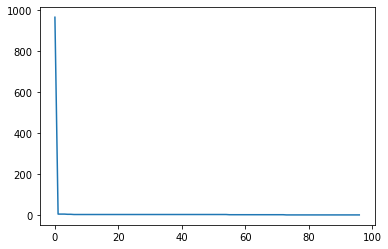

In [28]:
describe_components(investor_graph)

コンポーネント数: 97
ノード数に対するコンポーネント数の割合: 9.70%
投資家コンポーネント上位10件のサイズ
[898   2   2   2   2   2   2   1   1   1]
ネットワーク密度: 3.44%


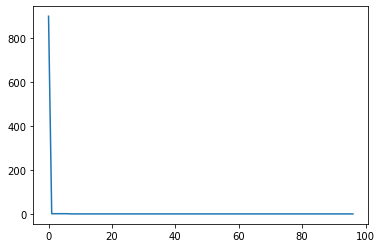

In [29]:
describe_components(company_graph)

# 基本情報の出力
国ごとのバリュエーション、Industryごとのバリュエーションを出力

In [30]:
df.sort_values(by=["Date Added"])

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
603,Veepee,$1.38,2007/7/20,France,E-commerce & direct-to-consumer,"[Summit Partners, Qatar Holding]",1.38,2007-07-20
3,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.60,2011-12-12
105,Vice Media,$5.70,2011/4/2,United States,Internet software & services,"[Technology Crossover Ventures, A&E Televisio...",5.70,2011-04-02
1,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.30,2012-12-01
380,Avant,$2.00,2012/12/17,United States,Artificial intelligence,"[RRE Ventures, Tiger Global, August Capital]",2.00,2012-12-17
...,...,...,...,...,...,...,...,...
635,Loadsmart,$1.30,2022/2/1,United States,"Supply chain, logistics, & delivery","[Chromo Invest, Maersk Growth, BlackRock]",1.30,2022-02-01
507,Wayflyer,$1.60,2022/2/1,Ireland,Fintech,"[QED Investors, DST Global, Left Lane Capital]",1.60,2022-02-01
998,Betterfly,$1.00,2022/2/1,Chile,Artificial intelligence,"[QED Investors, DST Global, Endeavor]",1.00,2022-02-01
482,Productboard,$1.70,2022/2/2,United States,Internet software & services,"[Index Ventures, Kleiner Perkins Caufield & B...",1.70,2022-02-02


In [31]:
stat_ind = ["mean", "sum", "min", "max", "count"]

In [32]:
country_group = df.groupby("Country").agg(stat_ind)
country_group.head()
cg_df = pd.DataFrame(country_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=country_group.index)
cg_df.sort_values(by=["sum"], ascending=False, inplace=True)
cg_df.head()

,mean,sum,min,max,count
Country,,,,,
United States,3.409294,1738.74,1.0,100.3,510.0
China,3.410359,569.53,1.0,140.0,167.0
United Kingdom,4.622564,180.28,1.0,40.0,39.0
India,3.035085,179.07,1.0,21.0,59.0
Germany,2.888000,72.20,1.0,11.0,25.0


In [33]:
industry_group = df.groupby("Category").agg(stat_ind)
industry_group.head()
ig_df = pd.DataFrame(industry_group["Valuation($B) flaot"][stat_ind].values, columns=stat_ind, index=industry_group.index)
ig_df.sort_values(by=["sum"], ascending=False, inplace=True)
ig_df.head()

,mean,sum,min,max,count
Category,,,,,
Fintech,3.921311,807.79,1.0,95.0,206.0
Internet software & services,2.952228,543.21,1.0,40.0,184.0
E-commerce & direct-to-consumer,2.955185,319.16,1.0,20.0,108.0
Artificial intelligence,4.077143,313.94,1.0,140.0,77.0
Other,4.795455,263.75,1.0,100.3,55.0


In [34]:
y = cg_df["mean"].values
x = cg_df.index.to_numpy()

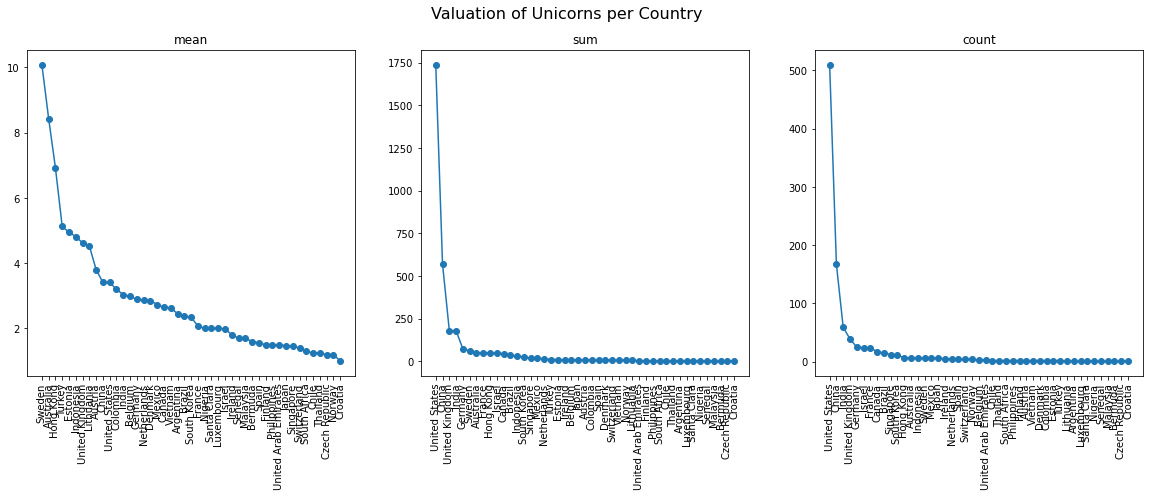

Complete output to ../out/202202/features/value_per_country.png


In [35]:
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Country", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    cg_df.sort_values(by=[col], ascending=False, inplace=True)
    y = cg_df[col].values
    x = cg_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join(out_dir, "features", "value_per_country.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

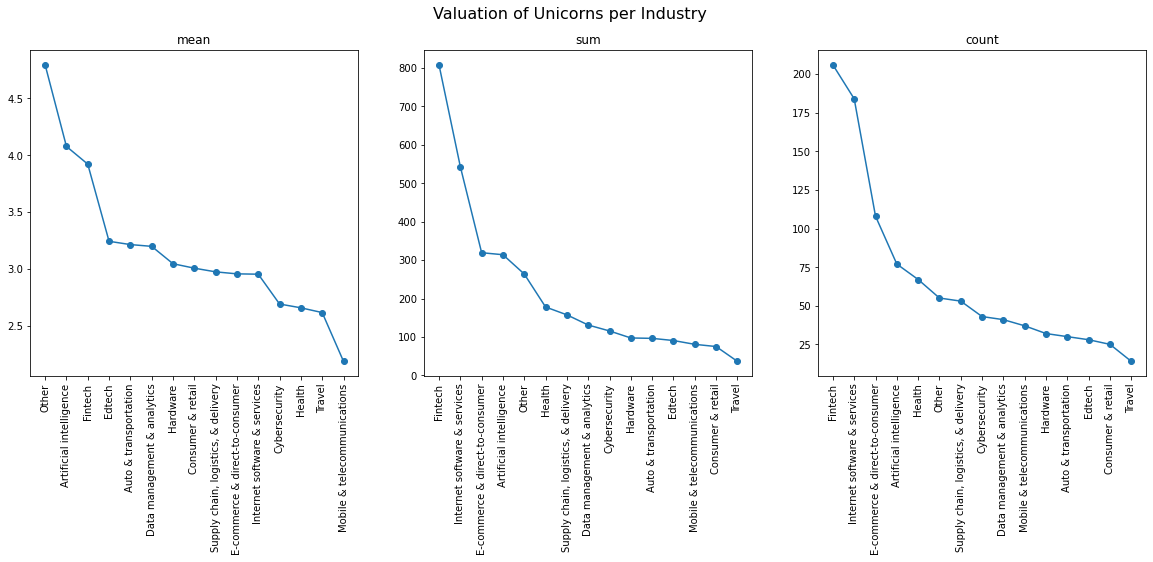

Complete output to ../out/202202/features/value_per_industry.png


In [36]:
nrows = 1
ncols = 3
fig = plt.figure(figsize=(20, 6))
fig.suptitle("Valuation of Unicorns per Industry", fontsize=16)
for ind, col in enumerate(["mean", "sum", "count"]):
    ax = fig.add_subplot(nrows, ncols, ind+1)
    ig_df.sort_values(by=[col], ascending=False, inplace=True)
    y = ig_df[col].values
    x = ig_df.index.to_numpy()
    ax.plot(x, y, marker="o")
    ax.set_title(f"{col}")
    plt.xticks(rotation=90)
plt.show()
fpath = os.path.join(out_dir, "features", "value_per_industry.png")
fig.savefig(fpath)
print("Complete output to {}".format(fpath))

# 時系列可視化

In [37]:
print(len(df))
tdf = df.set_index("DateTime Joined")
tdf

1000


,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot
DateTime Joined,,,,,,,
2017-04-07,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,"[Sequoia Capital China, SIG Asia Investments,...",140.0
2012-12-01,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.3
2014-01-23,Stripe,$95.00,2014/1/23,United States,Fintech,"[Khosla Ventures, LowercaseCapital, capitalG]",95.0
2011-12-12,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.6
2018-10-26,Epic Games,$42.00,2018/10/26,United States,Other,"[Tencent Holdings, KKR, Smash Ventures]",42.0
...,...,...,...,...,...,...,...
2022-01-26,Fever Labs,$1.00,2022/1/26,United States,Internet software & services,"[Accel, 14W, GS Growth]",1.0
2022-01-26,Minio,$1.00,2022/1/26,United States,Data management & analytics,"[General Catalyst, Nexus Venture Partners, D...",1.0
2022-01-27,Esusu,$1.00,2022/1/27,United States,Fintech,"[Next Play Ventures, Zeal Capital Partners, ...",1.0


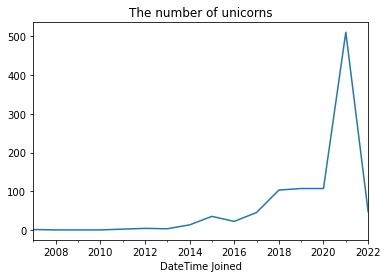

In [38]:
gdf = df.groupby(pd.Grouper(key="DateTime Joined", freq="Y")).agg("count")
gdf = gdf.reset_index().set_index("DateTime Joined")
gdf["Company"].plot(title="The number of unicorns")
plt.savefig(os.path.join(out_dir, "features", "n_unicorns_time_change.png"))

In [113]:
df.loc[:, "Year Joined"] = df["DateTime Joined"].apply(lambda x: x.year)
df.head()

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined,Year Joined
0,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,"[Sequoia Capital China, SIG Asia Investments,...",140.0,2017-04-07,2017
1,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.3,2012-12-01,2012
2,Stripe,$95.00,2014/1/23,United States,Fintech,"[Khosla Ventures, LowercaseCapital, capitalG]",95.0,2014-01-23,2014
3,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.6,2011-12-12,2011
4,Epic Games,$42.00,2018/10/26,United States,Other,"[Tencent Holdings, KKR, Smash Ventures]",42.0,2018-10-26,2018


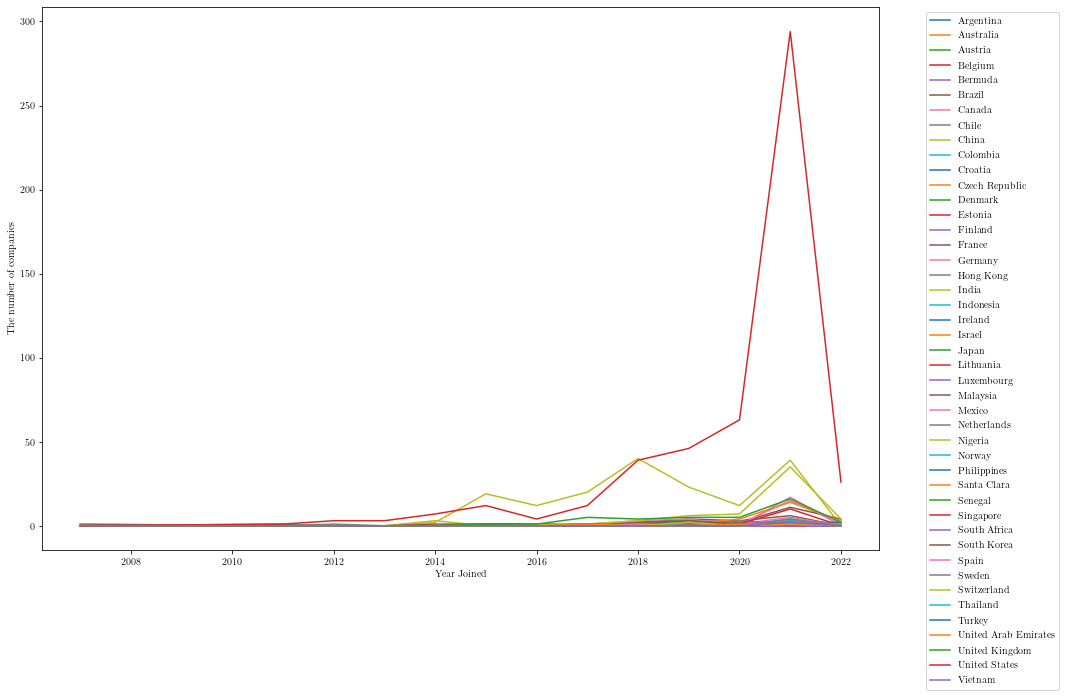

In [132]:
country_group_df = df.groupby(["Year Joined", "Country"], as_index=False).count()
country_series_df = country_group_df.pivot(index="Year Joined", columns="Country", values="Company").fillna(0)
country_series_df.plot(figsize=(15, 10))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left", ncol=2)
plt.ylabel("The number of companies")
fpath = os.path.join(out_dir, "features", "company_number_series_country.png")
plt.savefig(fpath, bbox_inches='tight')
country_series_df.to_csv(os.path.join(out_dir, "features", "company_number_series_country.csv"))

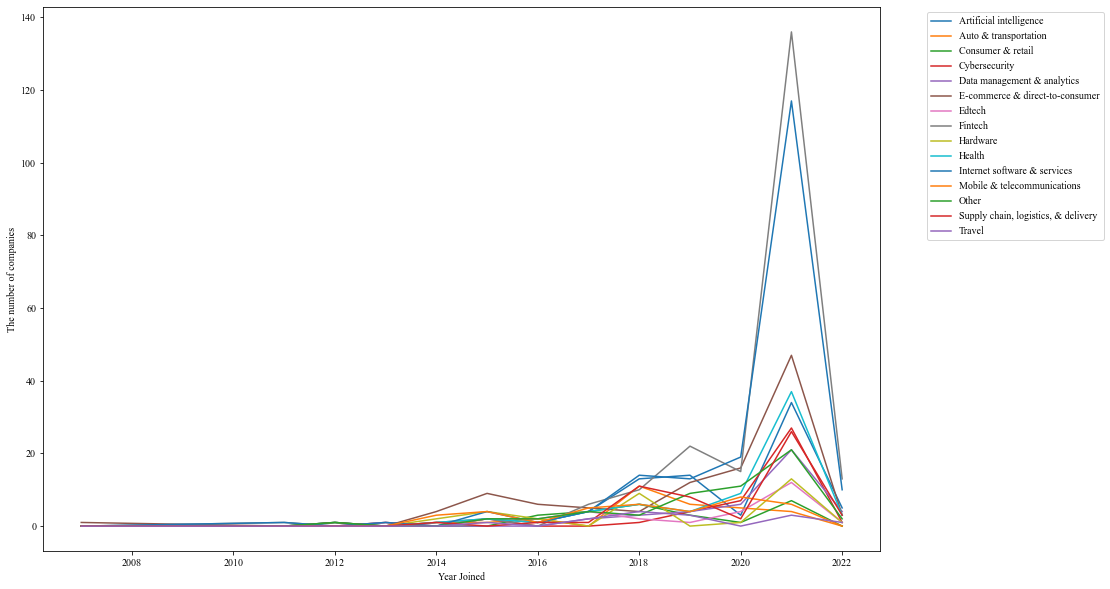

In [142]:
industry_group_df = df.groupby(["Year Joined", "Category"], as_index=False).count()
industry_series_df = industry_group_df.pivot(index="Year Joined", columns="Category", values="Company").fillna(0)
industry_series_df.plot(figsize=(15, 10))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left", ncol=1)
plt.ylabel("The number of companies")
fpath = os.path.join(out_dir, "features", "industry_number_series_country.png")
plt.savefig(fpath, bbox_inches='tight')
industry_series_df.to_csv(os.path.join(out_dir, "features", "industry_number_series_country.csv"))

In [103]:
df.head()

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
0,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,"[Sequoia Capital China, SIG Asia Investments,...",140.0,2017-04-07
1,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.3,2012-12-01
2,Stripe,$95.00,2014/1/23,United States,Fintech,"[Khosla Ventures, LowercaseCapital, capitalG]",95.0,2014-01-23
3,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.6,2011-12-12
4,Epic Games,$42.00,2018/10/26,United States,Other,"[Tencent Holdings, KKR, Smash Ventures]",42.0,2018-10-26


# ネットワークに時系列の要素を追加
カンパニーグラフは知識の流れを表していると解釈することができる。Date Joinedが遅い企業は、早い企業から知識を共有されていると考える。
そうした場合にどこの企業からどこの企業にVCを介して知識が伝播しているかを可視化する。

## ユニコーンネットワーク

In [39]:
company_graph_pd

,source,target
0,Ramp Financial,Addepar
1,Ramp Financial,Manner
2,Ramp Financial,Dune Analytics
3,Ramp Financial,GOAT
4,Ramp Financial,Tackle.io
...,...,...
13841,XtalPi,Mia.com
13842,CoinTracker,Fundbox
13843,Rightway,Fundbox
13844,Rightway,Lattice


In [40]:
uc_date_columns = ["Company", "Date Added", "Country", "Category", "Valuation($B) flaot"]
uc_date = df.loc[:, uc_date_columns]
uc_date.loc[:, "DateTime Joined"] = uc_date["Date Added"].apply(lambda x: datetime.datetime.strptime(x, "%Y/%m/%d"))
uc_date.set_index("Company", inplace=True)
elem_dict = uc_date.to_dict("index")

In [41]:
sources = []
targets = []
for source, target in company_graph_pd.values:
        if elem_dict[source]["DateTime Joined"] > elem_dict[target]["DateTime Joined"]:
            sources.append(target)
            targets.append(source)
        else:
            sources.append(source)
            targets.append(target)
comp_dgraph_df = pd.DataFrame({
    "source": sources,
    "target": targets
})
comp_dgraph_df

,source,target
0,Ramp Financial,Addepar
1,Manner,Ramp Financial
2,Ramp Financial,Dune Analytics
3,GOAT,Ramp Financial
4,Ramp Financial,Tackle.io
...,...,...
13841,Mia.com,XtalPi
13842,Fundbox,CoinTracker
13843,Rightway,Fundbox
13844,Lattice,Rightway


In [42]:
# チェック用
print(elem_dict["Flexport"]["Date Added"])
# print(elem_dict["Knotel"]["Date Added"])
print(elem_dict["Gong"]["Date Added"])
print(elem_dict["VAST Data"]["Date Added"])
# print(elem_dict["Dave"]["Date Added"])
# print(elem_dict["Udemy"]["Date Added"])

2018/4/30
2020/8/12
2020/4/16


In [43]:
comp_dgraph = nx.from_pandas_edgelist(comp_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [44]:
# 国・産業ごとにノードに色付けのためのCMAP生成
cmap = plt.get_cmap("tab20b")
country_l = df["Country"].unique()
industry_l = df["Category"].unique()
country_cmap = []
industry_cmap = []
val_size = []
max_val = df["Valuation($B) flaot"].max()
min_val = df["Valuation($B) flaot"].min()
diff = max_val - min_val
for n in comp_dgraph.nodes():
    industry = elem_dict[n]["Category"]
    ind_idx = np.where(industry_l == industry)
    country = elem_dict[n]["Country"]
    cou_idx = np.where(country_l == country)
    industry_cmap.append(cmap(ind_idx))
    country_cmap.append(cmap(cou_idx))
    val_size.append(
        100 + (elem_dict[n]["Valuation($B) flaot"] - min_val)/diff*900
    )

In [45]:
country_cmap = list(map(lambda x: tuple(x[0][0]), country_cmap))
industry_cmap = list(map(lambda x: tuple(x[0][0]), industry_cmap))

In [46]:
val_size[:10]

[118.77697841726618,
 107.57553956834532,
 101.94244604316546,
 100.0,
 117.4820143884892,
 101.61870503597122,
 100.0,
 133.66906474820144,
 104.53237410071942,
 103.23741007194245]

In [47]:
# plt.figure(figsize=(100, 100))
# nx.draw_circular(comp_dgraph, font_size=8, node_size=val_size, node_color=country_cmap)
# plt.savefig(os.path.join(out_dir, "sen2jun_dgraph"))

In [48]:
comp_dgraph_centrality_df = get_centrality(comp_dgraph)
comp_dgraph_centrality_df = comp_dgraph_centrality_df.reset_index().rename({"index": "Company"}, axis=1)
comp_dgraph_centrality_df.head()
comp_dgraph_centrality_df = pd.merge(comp_dgraph_centrality_df, df, on="Company", how="left")

In [49]:
comp_dgraph_centrality_df.to_csv(os.path.join(out_dir, "features", "directed_unicorn_centrality.csv"))

## VCネットワーク

In [50]:
investor_graph_pd

,source,target
0,Square Peg Capital,TDM Growth Partners
1,Square Peg Capital,Tiger Global Management
2,Orange Digital Ventures,Thrive Capital
3,Orange Digital Ventures,Access Industries
4,Orange Digital Ventures,Passion Capital
...,...,...
2500,Eurazeo,Aglae Ventures
2501,Nexus Venture Partners,Times Internet
2502,Version One Ventures,Bessemer Venture Partners
2503,Tiantu Capital Co.,Advantech Capital


In [51]:
datetime_df = analysis_invest_df[["Investor", "Oldest datetime joined"]]
datetime_df.columns = ["investor", "datetime"]
elem_dict = datetime_df.set_index("investor").to_dict("index")

In [52]:
sources = []
targets = []
for source, target in investor_graph_pd.values:
        if elem_dict[source]["datetime"] > elem_dict[target]["datetime"]:
            sources.append(target)
            targets.append(source)
        else:
            sources.append(source)
            targets.append(target)
investor_dgraph_df = pd.DataFrame({
    "source": sources,
    "target": targets
})
investor_dgraph_df

,source,target
0,TDM Growth Partners,Square Peg Capital
1,Tiger Global Management,Square Peg Capital
2,Thrive Capital,Orange Digital Ventures
3,Access Industries,Orange Digital Ventures
4,Orange Digital Ventures,Passion Capital
...,...,...
2500,Eurazeo,Aglae Ventures
2501,Nexus Venture Partners,Times Internet
2502,Bessemer Venture Partners,Version One Ventures
2503,Tiantu Capital Co.,Advantech Capital


In [53]:
investor_dgraph = nx.from_pandas_edgelist(investor_dgraph_df, source="source", target="target", create_using=nx.DiGraph)

In [54]:
investor_dgraph_centrality_df = get_centrality(investor_dgraph)
investor_dgraph_centrality_df = investor_dgraph_centrality_df.reset_index().rename({"index": "Investor"}, axis=1)
investor_dgraph_centrality_df = pd.merge(investor_dgraph_centrality_df, analysis_invest_df, on="Investor", how="left")
investor_dgraph_centrality_df.to_csv(os.path.join(out_dir, "features", "directed_investor_centrality.csv"))
investor_dgraph_centrality_df.head()

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,...,Total valuation($B),Valuation count,Mean valuation($B),#countries,Country set,#industries,Industry set,#unicorns,Unicorn set,Oldest datetime joined
0,TDM Growth Partners,0.003413,0.000008,3.390803e-21,0.015835,0.001138,0.002560,0.000853,1,1,...,2.95,2,1.475000,2,"{Australia, United States}",2,"{Internet software & services, E-commerce & di...",2,"{Pet Circle, Rokt}",2021-12-07
1,Square Peg Capital,0.001706,0.000000,8.753944e-20,0.015290,0.001476,0.001706,0.000000,0,0,...,1.95,1,1.950000,1,{United States},1,{Internet software & services},1,{Rokt},2021-12-16
2,Tiger Global Management,0.056314,0.004830,1.276377e-22,0.018561,0.001025,0.011092,0.045222,6,565,...,165.02,47,3.511064,11,"{United States, Estonia, Germany, India, Unite...",12,"{Fintech, Consumer & retail, Hardware, Mobile ...",47,"{Contentful, Veriff, SHEIN, NotCo, FalconX, Sa...",2016-06-22
3,Thrive Capital,0.023038,0.000926,4.037273e-13,0.025602,0.000845,0.011092,0.011945,8,139,...,40.38,16,2.523750,2,"{United Kingdom, United States}",6,"{Consumer & retail, Fintech, Cybersecurity, In...",16,"{TrialSpark, Cityblock Health, Justworks, Harr...",2018-02-16
4,Orange Digital Ventures,0.002560,0.000004,7.252479e-12,0.019228,0.000796,0.001706,0.000853,2,3,...,5.90,2,2.950000,2,"{France, United Kingdom}",2,"{Fintech, Internet software & services}",2,"{Deezer, Monzo}",2018-08-02


In [55]:
investor_dgraph_centrality_df.columns

Index(['Investor', 'Degree Centrality', 'Betweenness Centrality',
       'Eigen Centrality', 'Closeness Centrality', 'Page Rank',
       'In-degree Centrality', 'Out-degree Centrality', 'Elongation',
       'Expansion', 'Teacher Disciple Degree', 'Colleague Degree',
       'Unidirect Density', 'Bidirect Density', 'Total valuation($B)',
       'Valuation count', 'Mean valuation($B)', '#countries', 'Country set',
       '#industries', 'Industry set', '#unicorns', 'Unicorn set',
       'Oldest datetime joined'],
      dtype='object')

In [56]:
investor_data_df = investor_dgraph_centrality_df.drop(['Country set','Industry set', 'Unicorn set','Oldest datetime joined'], axis=1)
investor_data_df.corr()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
Degree Centrality,1.000000,0.868472,-0.012238,0.181832,0.054921,0.685853,0.971368,0.533917,0.591604,NaN,NaN,1.000000,NaN,0.825851,0.991628,0.043929,0.833960,0.906102,0.991628
Betweenness Centrality,0.868472,1.000000,-0.012113,0.176182,0.077839,0.691136,0.812431,0.445945,0.448254,NaN,NaN,0.868472,NaN,0.706795,0.869529,0.032447,0.735398,0.737953,0.869529
Eigen Centrality,-0.012238,-0.012113,1.000000,0.057298,0.157617,0.014149,-0.019247,-0.035558,-0.015930,NaN,NaN,-0.012238,NaN,-0.014666,-0.010834,-0.013040,0.004609,-0.007406,-0.010834
Closeness Centrality,0.181832,0.176182,0.057298,1.000000,0.317997,0.553593,0.036611,-0.010027,-0.137025,NaN,NaN,0.181832,NaN,0.071596,0.151599,-0.026236,0.170999,0.186290,0.151599
Page Rank,0.054921,0.077839,0.157617,0.317997,1.000000,0.372008,-0.055802,-0.208901,-0.120924,NaN,NaN,0.054921,NaN,0.002749,0.044428,-0.065973,0.034847,0.031497,0.044428
In-degree Centrality,0.685853,0.691136,0.014149,0.553593,0.372008,1.000000,0.493318,0.285139,0.192058,NaN,NaN,0.685853,NaN,0.483125,0.650866,0.024107,0.592494,0.637689,0.650866
Out-degree Centrality,0.971368,0.812431,-0.019247,0.036611,-0.055802,0.493318,1.000000,0.545090,0.644428,NaN,NaN,0.971368,NaN,0.829395,0.972783,0.044637,0.803383,0.874858,0.972783
Elongation,0.533917,0.445945,-0.035558,-0.010027,-0.208901,0.285139,0.545090,1.000000,0.714242,NaN,NaN,0.533917,NaN,0.476720,0.503921,0.190546,0.457454,0.612796,0.503921
Expansion,0.591604,0.448254,-0.015930,-0.137025,-0.120924,0.192058,0.644428,0.714242,1.000000,NaN,NaN,0.591604,NaN,0.591506,0.584220,0.195538,0.467933,0.644853,0.584220
Teacher Disciple Degree,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


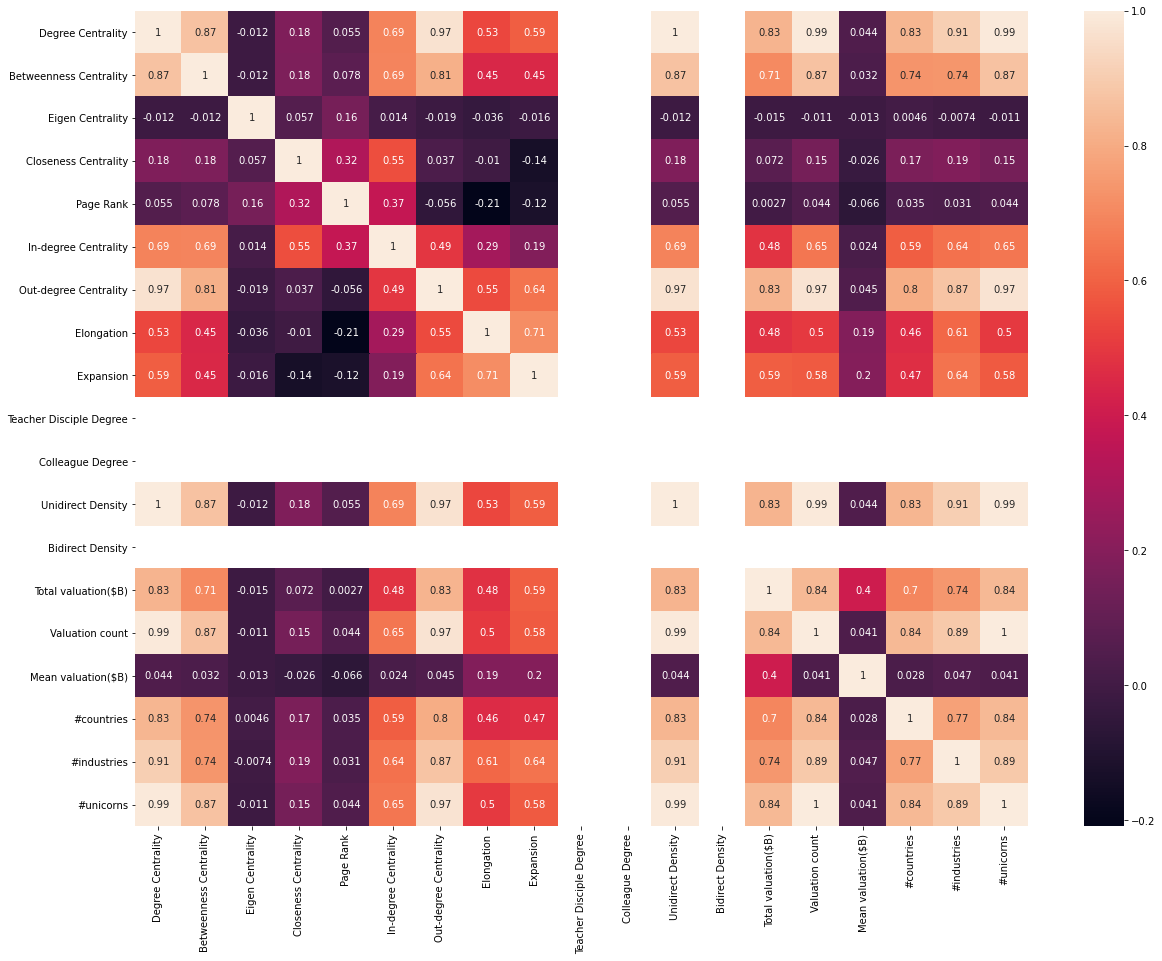

In [57]:
plt.figure(figsize=(20, 15))
sns.heatmap(investor_data_df.corr(), annot=True)
plt.savefig(os.path.join(out_dir, "features", "investor_correlation.png"))

In [58]:
value_df = df[["Company", "Valuation($B) flaot"]]
value_df.head()

,Company,Valuation($B) flaot
0,Bytedance,140.0
1,SpaceX,100.3
2,Stripe,95.0
3,Klarna,45.6
4,Epic Games,42.0


In [59]:
unicorn_data_df = pd.merge(comp_dgraph_centrality_df, value_df, on="Company", how="left").set_index("Company")

In [60]:
unicorn_data_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,...,Unidirect Density,Bidirect Density,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot_x,DateTime Joined,Valuation($B) flaot_y
Company,,,,,,,,,,,,,,,,,,,,,
Ramp Financial,0.027503,0.000858,1.716879e-47,0.104812,0.000548,0.009901,0.017602,8,149,1.0,...,0.013736,0.0,$3.90,2021/3/29,United States,Fintech,"[D1 Capital Partners, Stripe, Coatue Managem...",3.90,2021-03-29,3.90
Addepar,0.009901,0.000121,9.442767e-45,0.101186,0.001128,0.007701,0.002200,5,54,1.0,...,0.004945,0.0,$2.17,2021/6/15,United States,Fintech,"[8VC, D1 Capital Partners, Sway Ventures]",2.17,2021-06-15,2.17
Manner,0.025303,0.001076,7.329724e-75,0.045031,0.000559,0.005501,0.019802,6,351,1.0,...,0.012637,0.0,$1.30,2020/12/24,China,Other,"[Coatue Management, H Capital, Capital Today]",1.30,2020-12-24,1.30
Dune Analytics,0.022002,0.000000,9.556024e-05,0.270034,0.005245,0.022002,0.000000,0,0,1.0,...,0.010989,0.0,$1.00,2022/2/2,Norway,Data management & analytics,"[Multicoin Capital, Coatue Management, Drago...",1.00,2022-02-02,1.00
GOAT,0.007701,0.000157,1.772043e-69,0.043613,0.000396,0.002200,0.005501,7,330,1.0,...,0.003846,0.0,$3.70,2020/9/23,United States,E-commerce & direct-to-consumer,"[Upfront Ventures, Webb Investment Network, ...",3.70,2020-09-23,3.70


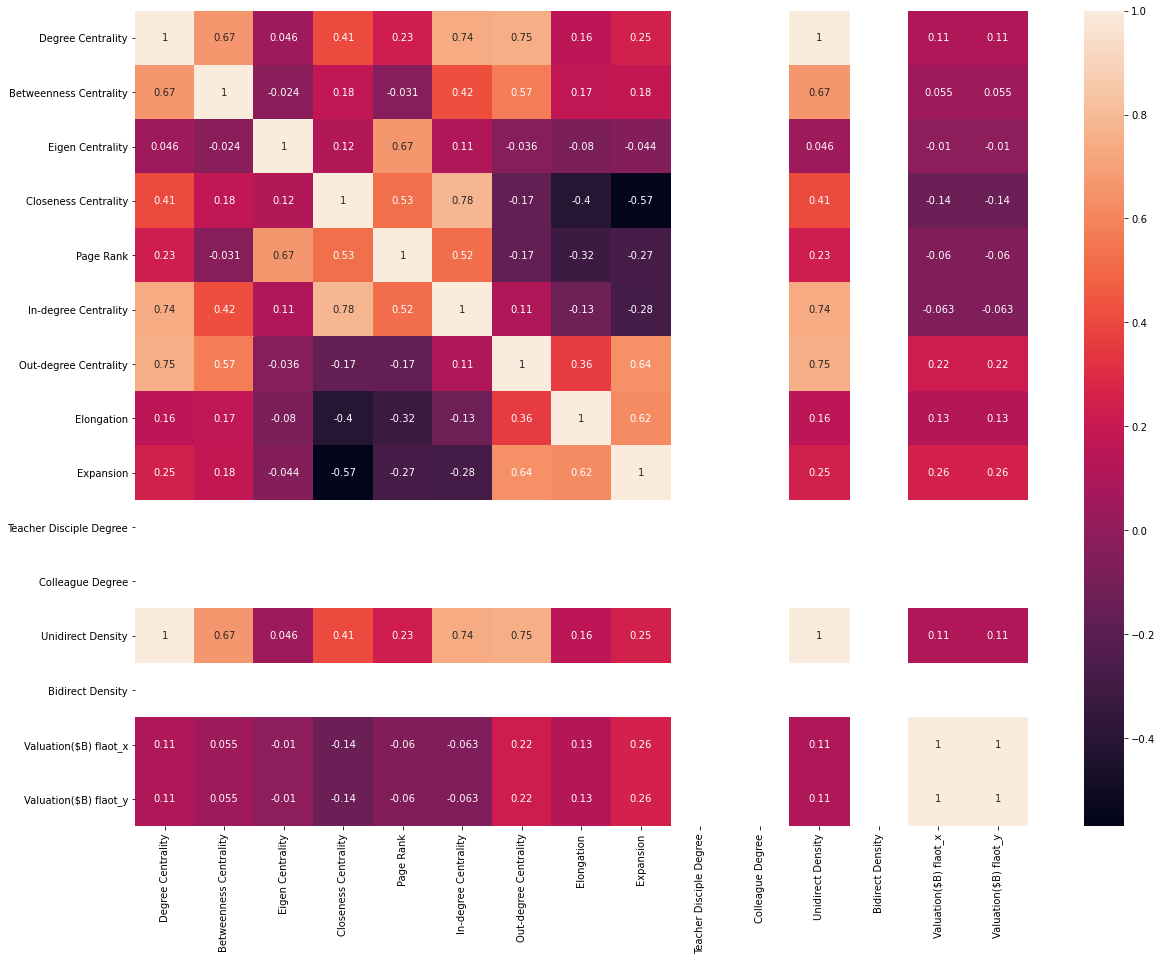

In [61]:
plt.figure(figsize=(20, 15))
sns.heatmap(unicorn_data_df.corr(), annot=True)
plt.savefig(os.path.join(out_dir, "features", "unicorn_correlation.png"))

valuationとユニコーン有向ネットワークの中心性との間に相関は見られない。

* 国ごと産業ごとの比較。
* 名寄せの問題。これは細かいので後回し
* 仮説を立てる。
  * VCのネットワークの意味は？
    * 何の関係を表してる？情報の流れ？
  * ユニコーンのネットワークの意味は？
    * 情報の流れ

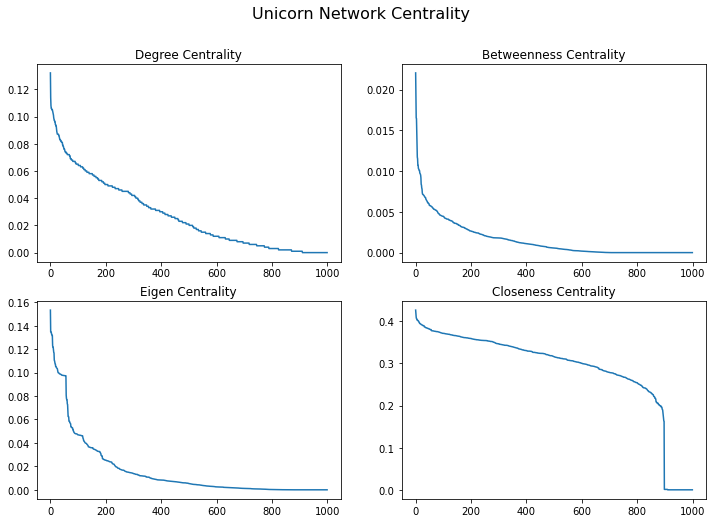

In [62]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Unicorn Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_comp_cent_df = company_centrality_df.sort_values(col, ascending=False)
y = sorted_comp_cent_df[col]
x = list(range(len(sorted_comp_cent_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join(out_dir, "features", "unicorn_network_centrality.png"))

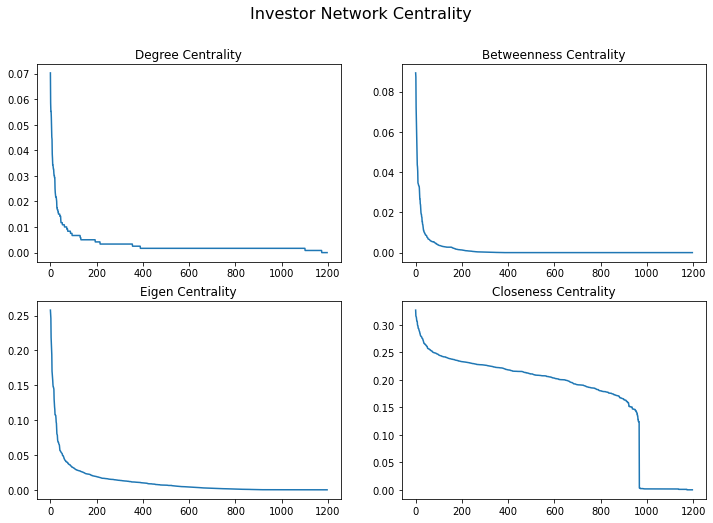

In [63]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle("Investor Network Centrality", fontsize=16)
ax1 = fig.add_subplot(221)
col = "Degree Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(222)
col = "Betweenness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(223)
col = "Eigen Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(224)
col = "Closeness Centrality"
sorted_df = investor_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
plt.savefig(os.path.join(out_dir, "features", "investor_network_centrality.png"))

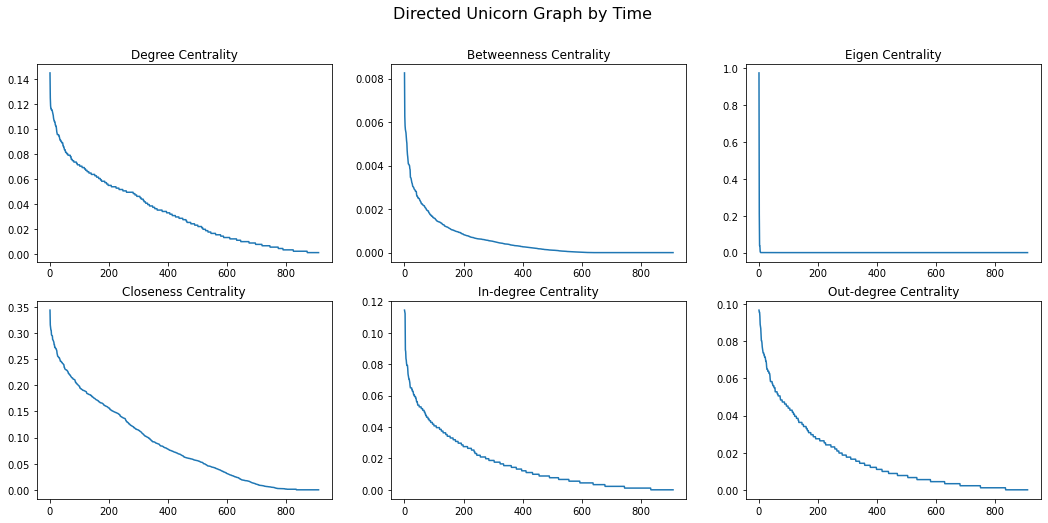

In [64]:
fig = plt.figure(figsize=(18, 8))
fig.suptitle("Directed Unicorn Graph by Time", fontsize=16)
ax1 = fig.add_subplot(231)
col = "Degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax1.set_title(col)
ax1.plot(x, y)
ax2 = fig.add_subplot(232)
col = "Betweenness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax2.set_title(col)
ax2.plot(x, y)
ax3 = fig.add_subplot(233)
col = "Eigen Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax3.set_title(col)
ax3.plot(x, y)
ax4 = fig.add_subplot(234)
col = "Closeness Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax4.set_title(col)
ax4.plot(x, y)
ax5 = fig.add_subplot(235)
col = "In-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax5.set_title(col)
ax5.plot(x, y)
ax6 = fig.add_subplot(236)
col = "Out-degree Centrality"
sorted_df = comp_dgraph_centrality_df.sort_values(col, ascending=False)
y = sorted_df[col]
x = list(range(len(sorted_df.index)))
ax6.set_title(col)
ax6.plot(x, y)
plt.savefig(os.path.join(out_dir, "features", "directed_unicorn_centrality.png"))

# データの出力

In [65]:
investor_centrality_df.to_csv(os.path.join(out_dir, "features", "investor_centrality.csv"))
company_centrality_df.to_csv(os.path.join(out_dir, "features", "unicorn_centrality.csv"))

In [66]:
unicorn_data_df.corr().to_csv(os.path.join(out_dir, "features", "unicorn_correlation.csv"))
investor_data_df.corr().to_csv(os.path.join(out_dir, "features", "investor_correlation.csv"))

## 企業 - 国・産業ネットワーク

In [67]:
df

,Company,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot,DateTime Joined
0,Bytedance,$140.00,2017/4/7,China,Artificial intelligence,"[Sequoia Capital China, SIG Asia Investments,...",140.0,2017-04-07
1,SpaceX,$100.30,2012/12/1,United States,Other,"[Founders Fund, Draper Fisher Jurvetson, Rot...",100.3,2012-12-01
2,Stripe,$95.00,2014/1/23,United States,Fintech,"[Khosla Ventures, LowercaseCapital, capitalG]",95.0,2014-01-23
3,Klarna,$45.60,2011/12/12,Sweden,Fintech,"[Institutional Venture Partners, Sequoia Capi...",45.6,2011-12-12
4,Epic Games,$42.00,2018/10/26,United States,Other,"[Tencent Holdings, KKR, Smash Ventures]",42.0,2018-10-26
...,...,...,...,...,...,...,...,...
995,Fever Labs,$1.00,2022/1/26,United States,Internet software & services,"[Accel, 14W, GS Growth]",1.0,2022-01-26
996,Minio,$1.00,2022/1/26,United States,Data management & analytics,"[General Catalyst, Nexus Venture Partners, D...",1.0,2022-01-26
997,Esusu,$1.00,2022/1/27,United States,Fintech,"[Next Play Ventures, Zeal Capital Partners, ...",1.0,2022-01-27
998,Betterfly,$1.00,2022/2/1,Chile,Artificial intelligence,"[QED Investors, DST Global, Endeavor]",1.0,2022-02-01


In [68]:
country_industry_df = pd.merge(comp_dgraph_df, df[["Company", "Country", "Category", "DateTime Joined"]], left_on="source", right_on="Company", how="left")
country_industry_df = pd.merge(country_industry_df, df[["Company", "Country", "Category", "DateTime Joined"]], left_on="target", right_on="Company", how="left", suffixes=["_source", "_target"])
country_industry_df = country_industry_df.drop(["Company_source", "Company_target"], axis=1)
country_industry_df.head()
country_industry_df.to_csv(os.path.join(out_dir, "edgelist", "country_industry_dgraph.csv"))

In [69]:
country_dgraph_df = country_industry_df.groupby(by=["Country_source", "Country_target"], as_index=False).agg({'source': 'count'})
country_dgraph_df.columns = ["source", "target", "weight"]
country_G = nx.from_pandas_edgelist(
    country_dgraph_df, create_using=nx.Graph, edge_attr=["weight"]
)
country_graph_df = nx.to_pandas_edgelist(country_G)
country_graph_df.to_csv(os.path.join(out_dir, "edgelist", "country_graph.csv"))
country_graph_matrix = nx.to_pandas_adjacency(country_G)
country_graph_matrix.to_csv(os.path.join(out_dir, "adjacency", "country_graph.csv"))

In [70]:
country_graph_matrix.max().max()

5390.0

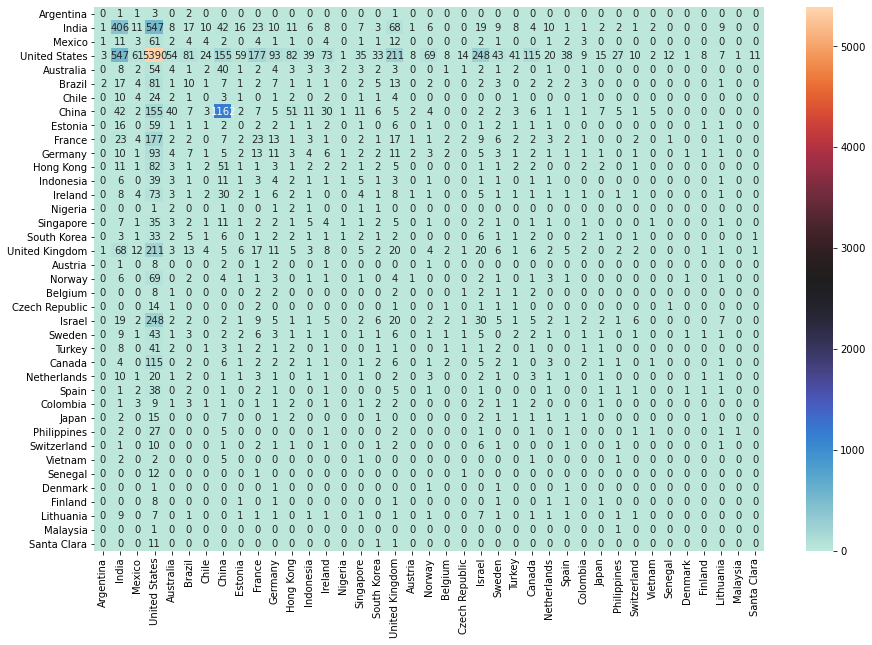

In [71]:
plt.figure(figsize=(15, 10))
center = (country_graph_matrix.max().max() - country_graph_matrix.min().min()) / 2
sns.heatmap(country_graph_matrix, center=center, annot=True, fmt=".0f")
plt.savefig(os.path.join(out_dir, "adjacency", "country_graph.png"))

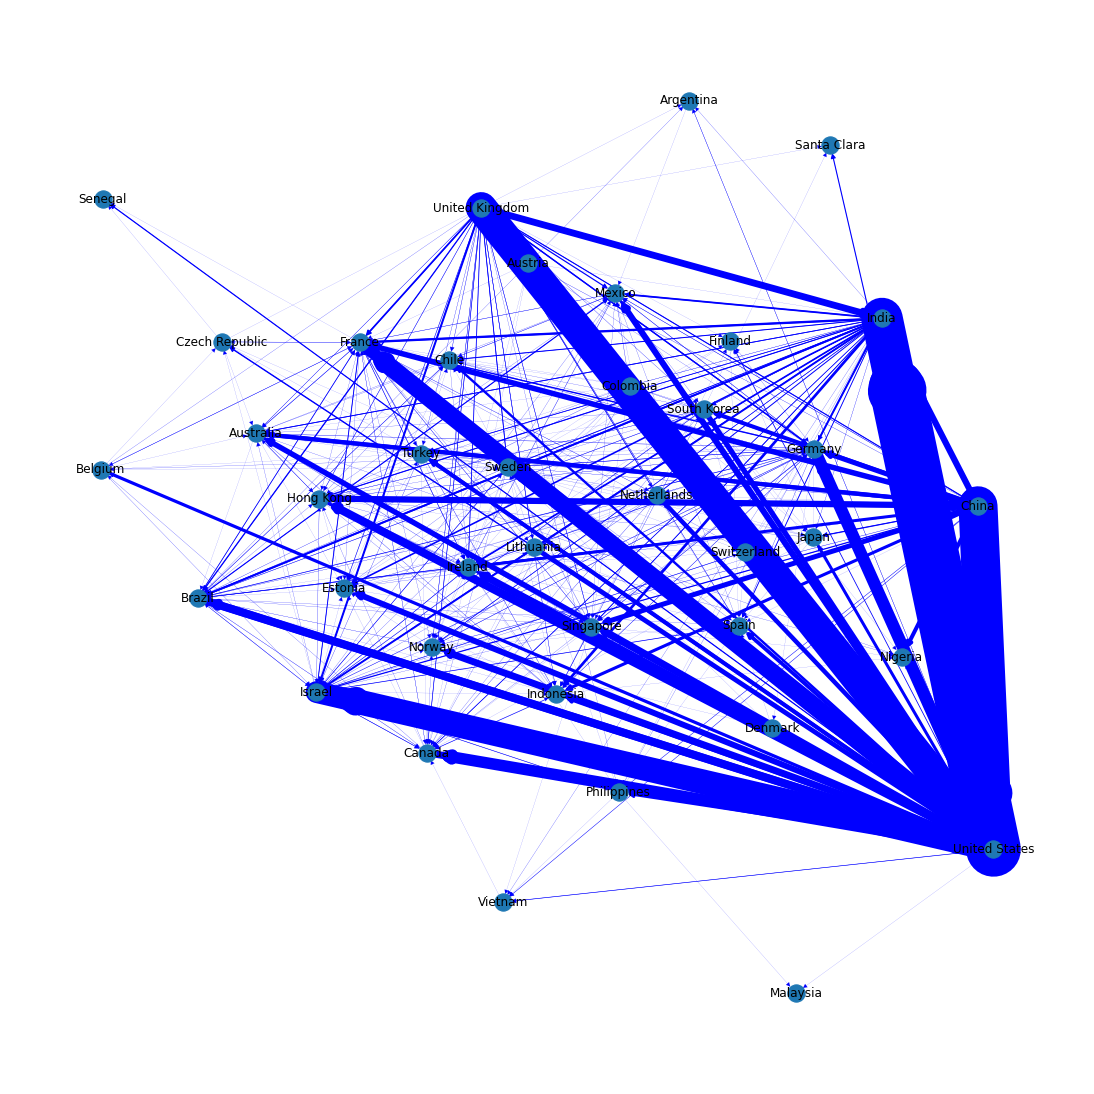

In [72]:
country_DG = nx.from_pandas_edgelist(
    country_dgraph_df, create_using=nx.DiGraph, edge_attr=["weight"]
)
edge_widths = [d['weight']/10 for _,_,d in country_DG.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    country_DG, width=edge_widths,
    pos=nx.kamada_kawai_layout(country_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join(out_dir, "edgelist", "country_dgraph.png"))
country_dgraph_df.to_csv(os.path.join(out_dir, "edgelist", "country_dgraph.csv"), sep="\t")

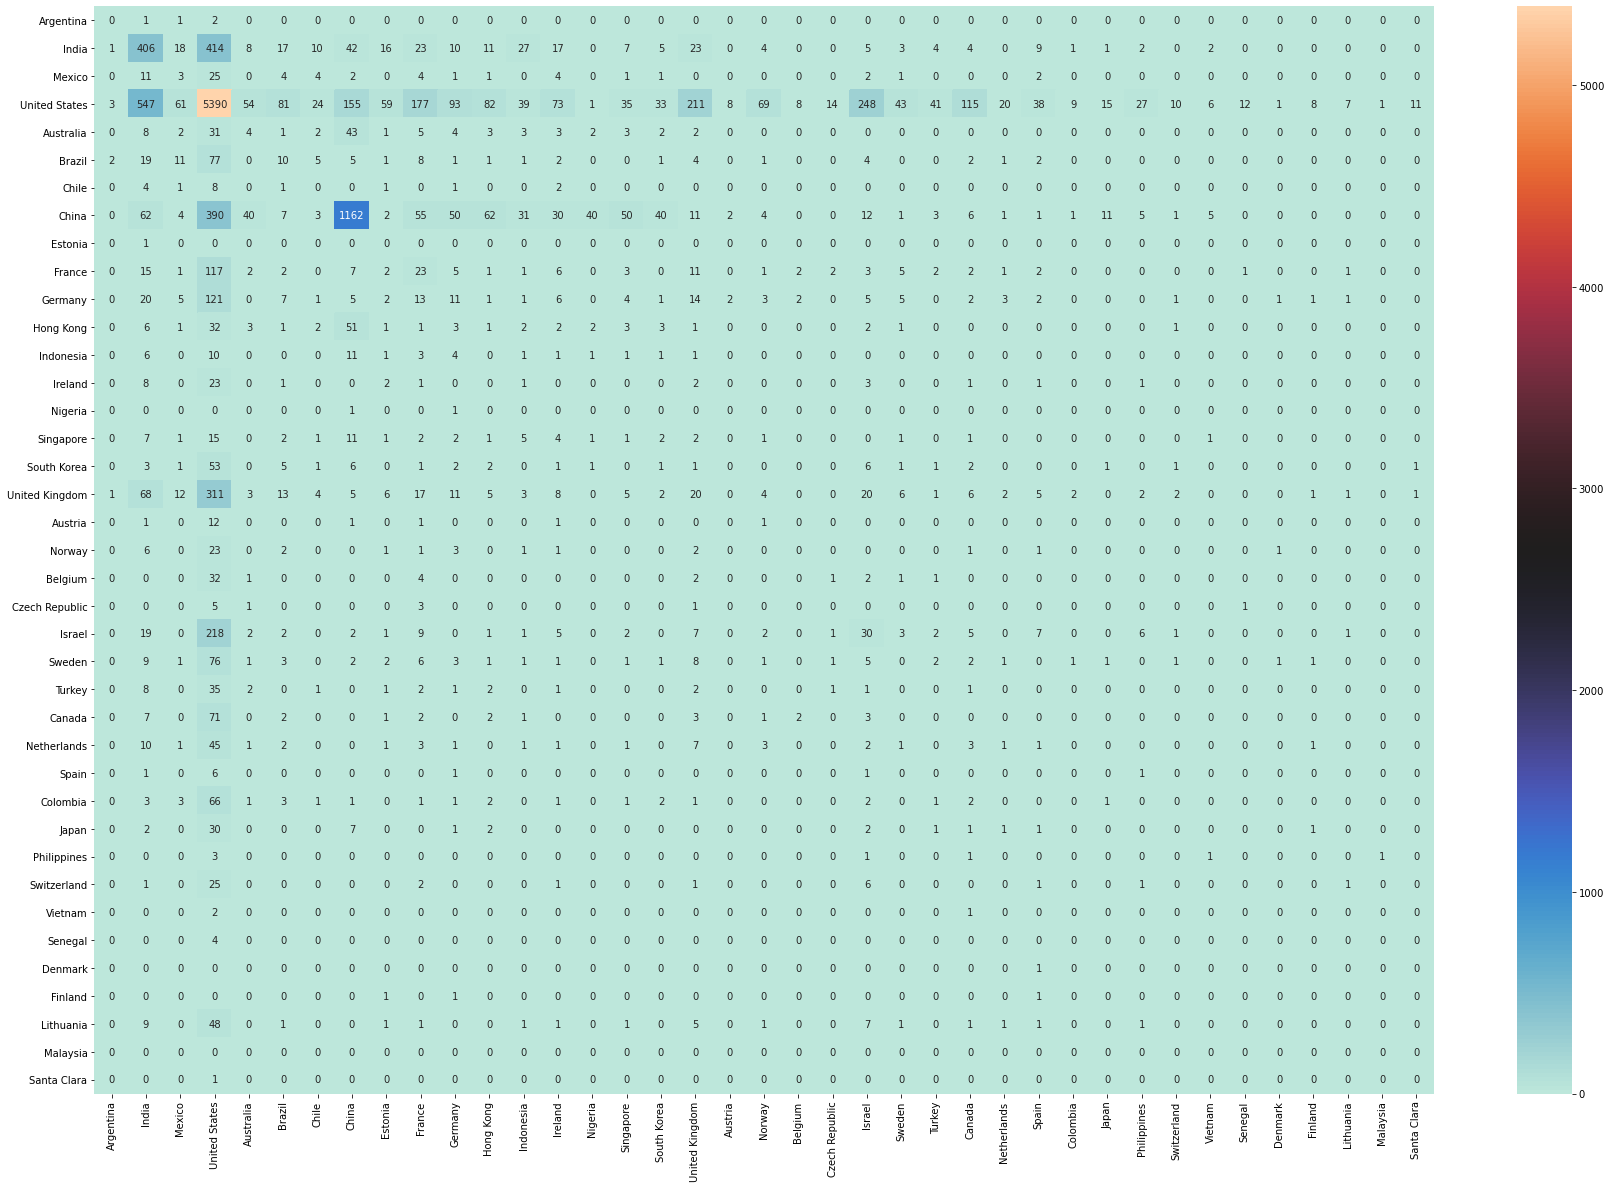

In [73]:
country_dgraph_matrix = nx.to_pandas_adjacency(country_DG)
plt.figure(figsize=(30, 20))
center = (country_dgraph_matrix.max().max() - country_dgraph_matrix.min().min()) / 2
sns.heatmap(country_dgraph_matrix, center=center, annot=True, fmt=".0f") # , annot_kws={"fontsize":3}
plt.savefig(os.path.join(out_dir, "adjacency", "country_dgraph.png"))
country_dgraph_matrix.to_csv(os.path.join(out_dir, "adjacency", "country_dgraph.csv"))

In [74]:
industry_dgraph_df = country_industry_df.groupby(by=["Category_source", "Category_target"], as_index=False).agg({"source": 'count'})
industry_dgraph_df.columns = ["source", "target", "weight"]
industry_G = nx.from_pandas_edgelist(industry_dgraph_df, create_using=nx.Graph, edge_attr="weight")
industry_graph_df = nx.to_pandas_edgelist(industry_G)
industry_graph_df.to_csv(os.path.join(out_dir, "edgelist", "industry_graph.csv"))
industry_graph_matrix = nx.to_pandas_adjacency(industry_G)
industry_graph_matrix.to_csv(os.path.join(out_dir, "adjacency", "industry_graph.csv"))
industry_graph_df.head()

,source,target,weight
0,Artificial intelligence,Artificial intelligence,90
1,Artificial intelligence,Auto & transportation,22
2,Artificial intelligence,Consumer & retail,42
3,Artificial intelligence,Cybersecurity,36
4,Artificial intelligence,Data management & analytics,71


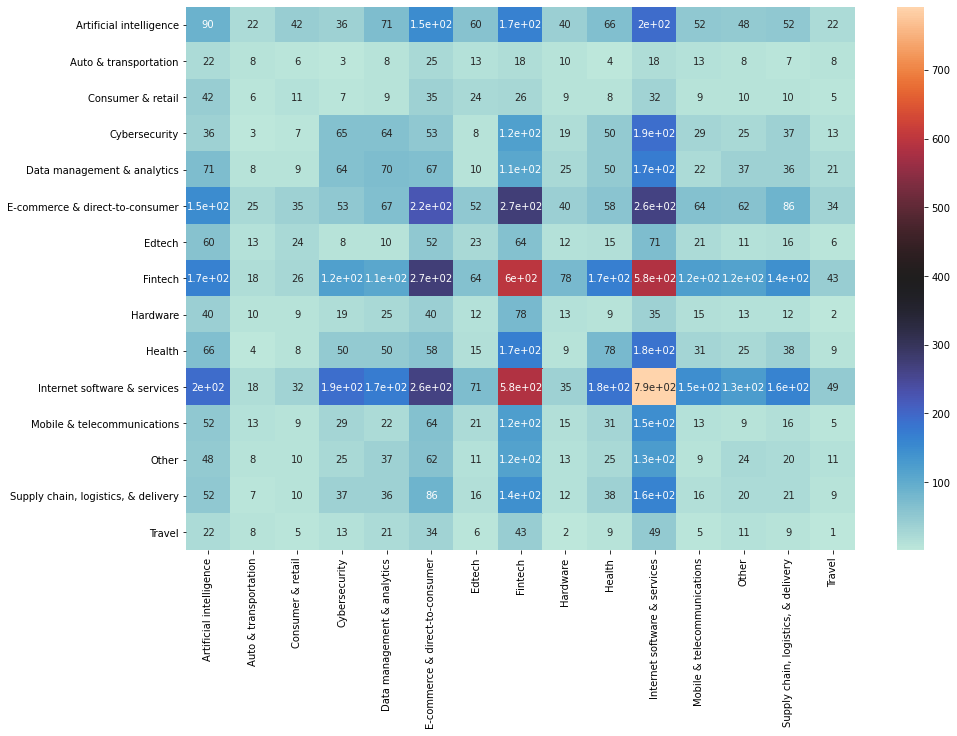

In [75]:
plt.figure(figsize=(15, 10))
center = (industry_graph_matrix.max().max() - industry_graph_matrix.min().min()) / 2
sns.heatmap(industry_graph_matrix, center=center, annot=True)
plt.savefig(os.path.join(out_dir, "adjacency", "industry_graph.png"))

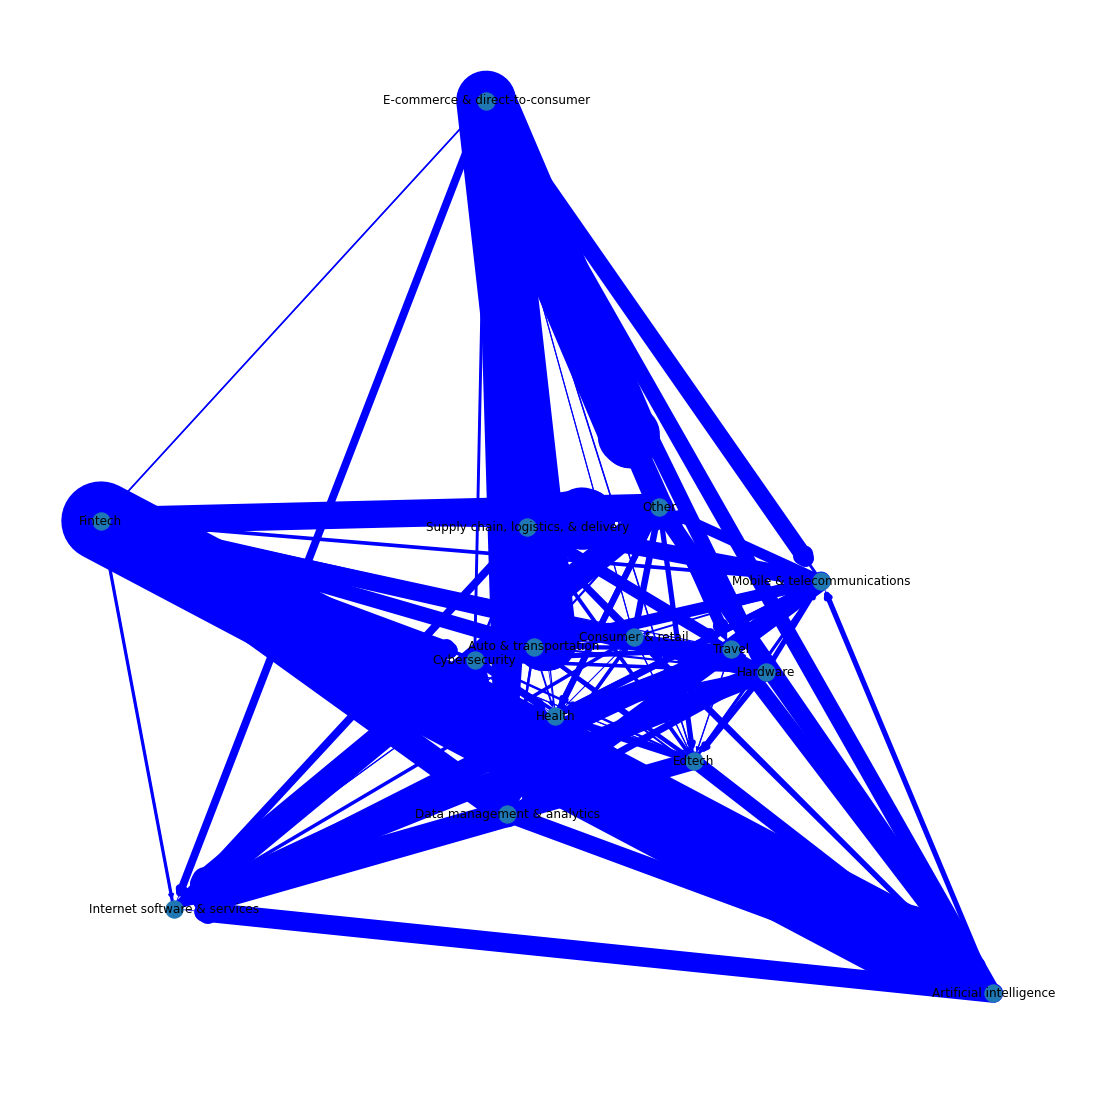

In [76]:
industry_DG = nx.from_pandas_edgelist(industry_dgraph_df, create_using=nx.DiGraph, edge_attr="weight")
edge_width = [v["weight"] * 0.1 for _, _, v in industry_G.edges(data=True)]
plt.figure(figsize=(15, 15))
nx.draw(
    industry_DG, width=edge_width, pos=nx.kamada_kawai_layout(industry_G),
    with_labels=True, edge_color="blue"
)
plt.savefig(os.path.join(out_dir, "edgelist", "industry_dgraph.png"))
industry_dgraph_df.to_csv(os.path.join(out_dir, "edgelist", "industry_dgraph.csv"), sep="\t")

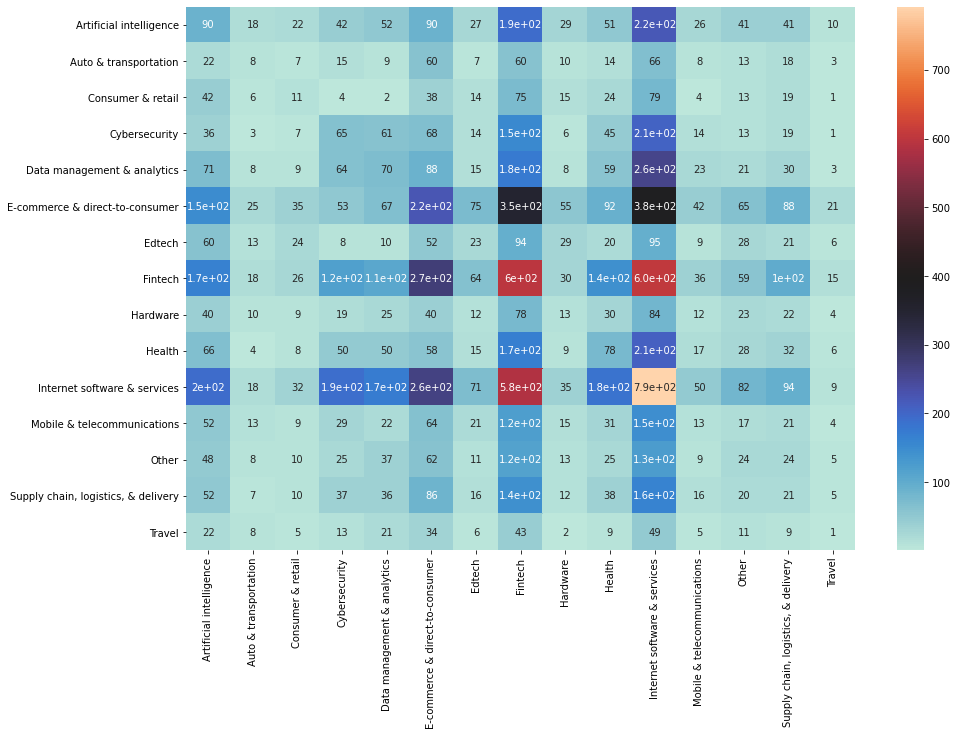

In [77]:
industry_dgraph_matrix = nx.to_pandas_adjacency(industry_DG)
plt.figure(figsize=(15, 10))
center = (industry_dgraph_matrix.max().max() - industry_dgraph_matrix.min().min()) / 2
sns.heatmap(industry_dgraph_matrix, center=center, annot=True)
plt.savefig(os.path.join(out_dir, "adjacency", "industry_dgraph.png"))
industry_dgraph_matrix.to_csv(os.path.join(out_dir, "adjacency", "industry_dgraph.csv"))

In [78]:
country_centrality_df = get_centrality(country_G)
industry_centrality_df = get_centrality(industry_G)

In [79]:
country_centrality_df.to_csv(os.path.join(out_dir, "features", "country_unicorn_centrality.csv"))

In [80]:
industry_centrality_df.to_csv(os.path.join(out_dir, "features", "industry_unicorn_centrality.csv"))

# 回帰分析

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

## ユニコーン回帰分析

In [82]:
unicorn_data_df.head()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,...,Unidirect Density,Bidirect Density,Valuation ($B),Date Added,Country,Category,Select Investors,Valuation($B) flaot_x,DateTime Joined,Valuation($B) flaot_y
Company,,,,,,,,,,,,,,,,,,,,,
Ramp Financial,0.027503,0.000858,1.716879e-47,0.104812,0.000548,0.009901,0.017602,8,149,1.0,...,0.013736,0.0,$3.90,2021/3/29,United States,Fintech,"[D1 Capital Partners, Stripe, Coatue Managem...",3.90,2021-03-29,3.90
Addepar,0.009901,0.000121,9.442767e-45,0.101186,0.001128,0.007701,0.002200,5,54,1.0,...,0.004945,0.0,$2.17,2021/6/15,United States,Fintech,"[8VC, D1 Capital Partners, Sway Ventures]",2.17,2021-06-15,2.17
Manner,0.025303,0.001076,7.329724e-75,0.045031,0.000559,0.005501,0.019802,6,351,1.0,...,0.012637,0.0,$1.30,2020/12/24,China,Other,"[Coatue Management, H Capital, Capital Today]",1.30,2020-12-24,1.30
Dune Analytics,0.022002,0.000000,9.556024e-05,0.270034,0.005245,0.022002,0.000000,0,0,1.0,...,0.010989,0.0,$1.00,2022/2/2,Norway,Data management & analytics,"[Multicoin Capital, Coatue Management, Drago...",1.00,2022-02-02,1.00
GOAT,0.007701,0.000157,1.772043e-69,0.043613,0.000396,0.002200,0.005501,7,330,1.0,...,0.003846,0.0,$3.70,2020/9/23,United States,E-commerce & direct-to-consumer,"[Upfront Ventures, Webb Investment Network, ...",3.70,2020-09-23,3.70


In [83]:
unicorn_data_df.columns

Index(['Degree Centrality', 'Betweenness Centrality', 'Eigen Centrality',
       'Closeness Centrality', 'Page Rank', 'In-degree Centrality',
       'Out-degree Centrality', 'Elongation', 'Expansion',
       'Teacher Disciple Degree', 'Colleague Degree', 'Unidirect Density',
       'Bidirect Density', 'Valuation ($B) ', 'Date Added', 'Country',
       'Category', 'Select Investors', 'Valuation($B) flaot_x',
       'DateTime Joined', 'Valuation($B) flaot_y'],
      dtype='object')

In [84]:
train_df = unicorn_data_df.drop([
    'Valuation ($B) ', 'Date Added', 'Country', 'Category', 'Select Investors',
    'DateTime Joined', 'Valuation($B) flaot_y', "Colleague Degree", "Bidirect Density",
    "Teacher Disciple Degree"
], axis=1)
# [
#     'Valuation($B)', 'Date Joined', 'Country', 'Industry', 'Select Investors', 'DateTime Joined', 'Valuation($B) flaot_y', 'Degree Centrality',
#     'Elongation', 'Expansion', 'Unidirect Density', 'Teacher Disciple Degree', 'Colleague Degree', 'Bidirect Density', 'In-degree Centrality',
#     'Page Rank'
# ] -> r2: 0.0615236981958418
d = ["Betweenness Centrality", "Elongation", "Page Rank", "Eigen Centrality",
     "Closeness Centrality", 'In-degree Centrality', "Degree Centrality", "Unidirect Density"]
train_df.drop(d, axis=1, inplace=True)
train_df.head()

,Out-degree Centrality,Expansion,Valuation($B) flaot_x
Company,,,
Ramp Financial,0.017602,149,3.90
Addepar,0.002200,54,2.17
Manner,0.019802,351,1.30
Dune Analytics,0.000000,0,1.00
GOAT,0.005501,330,3.70


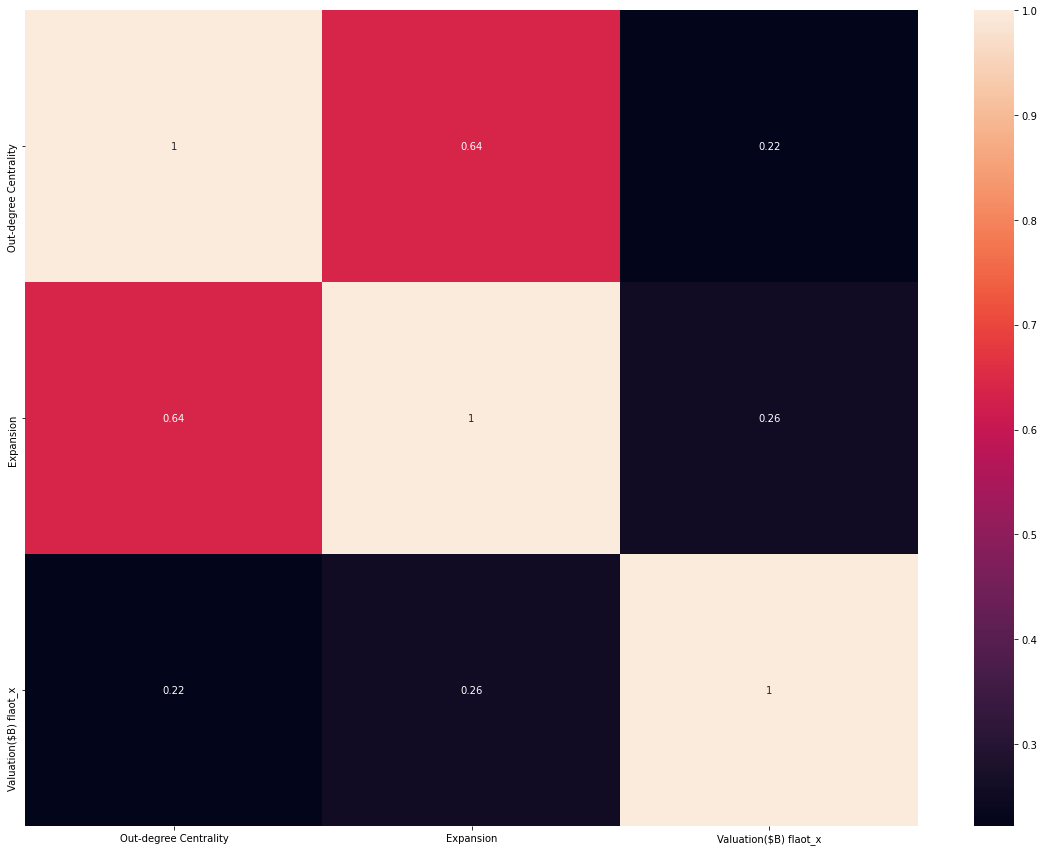

In [85]:
plt.figure(figsize=(20, 15))
sns.heatmap(train_df.corr(), annot=True)

In [86]:
sc = StandardScaler()
data_std = sc.fit_transform(train_df)
x, y = data_std[:,:-1], data_std[:, -1]
y = y.reshape(len(y), 1)
x_df = pd.DataFrame(x, columns=train_df.columns[:-1])
y_df = pd.DataFrame(y, columns=[train_df.columns[-1]])

In [87]:
mod = sm.OLS(y_df, sm.add_constant(x_df))
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Valuation($B) flaot_x   R-squared:                       0.071
Model:                               OLS   Adj. R-squared:                  0.069
Method:                    Least Squares   F-statistic:                     34.75
Date:                   Sun, 27 Feb 2022   Prob (F-statistic):           2.88e-15
Time:                           21:22:30   Log-Likelihood:                -1257.6
No. Observations:                    910   AIC:                             2521.
Df Residuals:                        907   BIC:                             2536.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -4.163e-17      0.032   -1.3e-15      1.000      -0.063       0.063
Out-degree Centrality     0.0978      0.042      2.346      0.019       0.016       0.180
Expansion                 0.1933      0.042      4.639      0.000       0.112       0.275
==============================================================================
Omnibus:                     1549.349   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           972542.841
Skew:                          10.932   Prob(JB):                         0.00
Kurtosis:                     161.655   Cond. No.                         2.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
train_df.corr()

,Out-degree Centrality,Expansion,Valuation($B) flaot_x
Out-degree Centrality,1.000000,0.640661,0.221652
Expansion,0.640661,1.000000,0.255993
Valuation($B) flaot_x,0.221652,0.255993,1.000000


In [89]:
np.sign(result.params[1:]) - np.sign(train_df.corr()["Valuation($B) flaot_x"][:-1].values)

Out-degree Centrality    0.0
Expansion                0.0
dtype: float64

In [90]:
with open(os.path.join(out_dir, "features", "unicorn_regression.csv"), "w", encoding="utf-8") as f:
    f.write(result.summary().as_csv())

## VC回帰分析

In [91]:
investor_data_df.head()

,Investor,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
0,TDM Growth Partners,0.003413,0.000008,3.390803e-21,0.015835,0.001138,0.002560,0.000853,1,1,1.0,0.0,0.001705,0.0,2.95,2,1.475000,2,2,2
1,Square Peg Capital,0.001706,0.000000,8.753944e-20,0.015290,0.001476,0.001706,0.000000,0,0,1.0,0.0,0.000853,0.0,1.95,1,1.950000,1,1,1
2,Tiger Global Management,0.056314,0.004830,1.276377e-22,0.018561,0.001025,0.011092,0.045222,6,565,1.0,0.0,0.028133,0.0,165.02,47,3.511064,11,12,47
3,Thrive Capital,0.023038,0.000926,4.037273e-13,0.025602,0.000845,0.011092,0.011945,8,139,1.0,0.0,0.011509,0.0,40.38,16,2.523750,2,6,16
4,Orange Digital Ventures,0.002560,0.000004,7.252479e-12,0.019228,0.000796,0.001706,0.000853,2,3,1.0,0.0,0.001279,0.0,5.90,2,2.950000,2,2,2


In [92]:
investor_data_df.describe()

,Degree Centrality,Betweenness Centrality,Eigen Centrality,Closeness Centrality,Page Rank,In-degree Centrality,Out-degree Centrality,Elongation,Expansion,Teacher Disciple Degree,Colleague Degree,Unidirect Density,Bidirect Density,Total valuation($B),Valuation count,Mean valuation($B),#countries,#industries,#unicorns
count,1173.000000,1173.000000,1.173000e+03,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.0,1173.0,1173.000000,1173.0,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000,1173.000000
mean,0.003644,0.000081,1.626615e-03,0.011729,0.000853,0.001822,0.001822,1.503836,45.531969,1.0,0.0,0.001821,0.0,8.172540,2.389599,2.943423,1.376812,1.697357,2.389599
std,0.006083,0.000360,2.916495e-02,0.009044,0.000373,0.001661,0.005089,2.240496,159.251197,0.0,0.0,0.003039,0.0,23.034512,4.561389,6.145522,1.184891,1.642431,4.561389
min,0.000853,0.000000,3.432014e-49,0.000000,0.000491,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.000426,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.001706,0.000000,3.771718e-42,0.001706,0.000551,0.000853,0.000000,0.000000,0.000000,1.0,0.0,0.000853,0.0,1.200000,1.000000,1.100000,1.000000,1.000000,1.000000
50%,0.001706,0.000000,4.989213e-21,0.011499,0.000715,0.001706,0.000853,1.000000,1.000000,1.0,0.0,0.000853,0.0,2.300000,1.000000,1.700000,1.000000,1.000000,1.000000
75%,0.003413,0.000009,8.017587e-12,0.019510,0.001029,0.001706,0.001706,2.000000,3.000000,1.0,0.0,0.001705,0.0,5.500000,2.000000,2.950000,1.000000,2.000000,2.000000
max,0.071672,0.005387,8.332965e-01,0.035640,0.003261,0.020478,0.056314,10.000000,870.000000,1.0,0.0,0.035806,0.0,341.880000,57.000000,100.300000,16.000000,13.000000,57.000000


In [93]:
investor_data_df = investor_data_df.set_index("Investor")

In [94]:
train_df = investor_data_df.drop(["Valuation count", "Mean valuation($B)", "Bidirect Density", "Colleague Degree", "Teacher Disciple Degree"], axis=1)
target = train_df["Total valuation($B)"]
train_df.drop("Total valuation($B)", axis=1, inplace=True)
train_df["Total valuation($B)"] = target
d = [
    "Degree Centrality", 'Closeness Centrality', 'Page Rank', 'Unidirect Density', '#countries', '#industries', "Elongation",
    'Eigen Centrality', 'In-degree Centrality', 'Out-degree Centrality'
]
train_df = train_df.drop(d, axis=1)
train_df.describe()

,Betweenness Centrality,Expansion,#unicorns,Total valuation($B)
count,1173.000000,1173.000000,1173.000000,1173.000000
mean,0.000081,45.531969,2.389599,8.172540
std,0.000360,159.251197,4.561389,23.034512
min,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,1.000000,1.200000
50%,0.000000,1.000000,1.000000,2.300000
75%,0.000009,3.000000,2.000000,5.500000
max,0.005387,870.000000,57.000000,341.880000


In [95]:
sc = StandardScaler()
data_std = sc.fit_transform(train_df)
x, y = data_std[:,:-1], data_std[:, -1]
# y = sc.fit_transform(y)
y = y.reshape(len(y), 1)
x_df = pd.DataFrame(x, columns=train_df.columns[:-1])
y_df = pd.DataFrame(y, columns=[train_df.columns[-1]])

In [96]:
mod = sm.OLS(y_df, sm.add_constant(x_df))
result = mod.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Total valuation($B)   R-squared:                       0.726
Model:                             OLS   Adj. R-squared:                  0.725
Method:                  Least Squares   F-statistic:                     1031.
Date:                 Sun, 27 Feb 2022   Prob (F-statistic):               0.00
Time:                         21:22:31   Log-Likelihood:                -905.78
No. Observations:                 1173   AIC:                             1820.
Df Residuals:                     1169   BIC:                             1840.
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -5.204e-17      0.015   -3.4e-15      1.000      -0.030       0.030
Betweenness Centrality    -0.0697      0.031     -2.222      0.026      -0.131      -0.008
Expansion                  0.1446      0.019      7.574      0.000       0.107       0.182
#unicorns                  0.8185      0.035     23.691      0.000       0.751       0.886
==============================================================================
Omnibus:                     1493.654   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           234357.894
Skew:                           6.684   Prob(JB):                         0.00
Kurtosis:                      70.944   Cond. No.                         4.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
train_df.columns[:-1]

Index(['Betweenness Centrality', 'Expansion', '#unicorns'], dtype='object')

In [98]:
np.sign(result.params[1:]) - np.sign(train_df.corr()["Total valuation($B)"][:-1].values)

Betweenness Centrality   -2.0
Expansion                 0.0
#unicorns                 0.0
dtype: float64

In [99]:
with open(os.path.join(out_dir, "features", "investor_regression.csv"), "w", encoding="utf-8") as f:
    f.write(result.summary().as_csv())